# R Packages Maintainer

In [2]:
import pandas
import re

from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf')

data = pandas.DataFrame.from_csv('../data/github-cran-150601.csv')
data['Date'] = pandas.to_datetime(data['Date'])

In [3]:
print len(data.drop_duplicates('Maintainer')), 'maintainer values'

8533 maintainer values


In [4]:
def clean_maintainer(v):
    v = v if isinstance(v, str) else ''
    words = map(str.strip, v.split(' '))
    words = map(lambda w: re.sub(r'[^@a-zA-Z]', '', w), words)
    words = filter(lambda w: len(w) > 2 and '@' not in w, words)
    words.sort()
    return ' '.join(words)

data['Maintainer_can'] = data['Maintainer'].apply(clean_maintainer)
print len(data.drop_duplicates('Maintainer_can')), 'canonical maintainer values'

6044 canonical maintainer values


In [5]:
_maint_first = data.sort('Date').drop_duplicates('Maintainer_can').set_index('Maintainer_can')[['Date', 'InGitHub', 'InCRAN']]
_maint_last = data.sort('Date', ascending=False).drop_duplicates('Maintainer_can').set_index('Maintainer_can')[['Date', 'InGitHub', 'InCRAN']]

github = data.query('InGitHub == 1').sort('Date')
cran = data.query('InCRAN == 1').sort('Date')

__f = (lambda d,rev,name: d.drop_duplicates('Maintainer_can', take_last=rev)
               .set_index('Maintainer_can')[['Date']]
               .rename(columns={'Date':name}))

maintainers = __f(github, False, 'GitHubFirstDate').join(
    [__f(github, True, 'GitHubLastDate'), __f(cran, False, 'CRANFirstDate'), __f(cran, True, 'CRANLastDate'),],
    how='outer')

In [6]:
maintainers['DaysOnGitHub'] = maintainers['GitHubLastDate'] - maintainers['GitHubFirstDate']
maintainers['DaysOnCRAN'] = maintainers['CRANLastDate'] - maintainers['CRANFirstDate']
# We consider CRAN first
maintainers['CRANFirst-->GHFirst'] = maintainers['GitHubFirstDate'] - maintainers['CRANFirstDate'] 
maintainers['CRANLast-->GitHubLast'] = maintainers['GitHubLastDate'] - maintainers['CRANLastDate']
maintainers['CRANLast-->GitHubFirst'] = maintainers['GitHubFirstDate'] - maintainers['CRANLastDate']
maintainers['CRANFirst-->GitHubLast'] = maintainers['GitHubLastDate'] - maintainers['CRANFirstDate']

fields = ['DaysOnGitHub', 'DaysOnCRAN', 'CRANFirst-->GHFirst', 'CRANLast-->GitHubLast', 'CRANLast-->GitHubFirst', 'CRANFirst-->GitHubLast']
for field in fields:
    maintainers[field] = maintainers[field].astype('timedelta64[D]')

In [7]:
from collections import OrderedDict

testdata = OrderedDict([
    ('all', maintainers), 
    ('on CRAN', maintainers.dropna(subset=['CRANFirstDate', 'CRANLastDate'])),
    ('on GH', maintainers.dropna(subset=['GitHubFirstDate', 'GitHubLastDate'])),
    ('on both', maintainers.dropna()),
    ('on both at least 1 minute', maintainers.dropna().query('GitHubFirstDate <= CRANLastDate and GitHubLastDate >= CRANFirstDate')),
    ('first on CRAN', maintainers.dropna().query('CRANFirstDate <= GitHubFirstDate')),
    ('first on GH', maintainers.dropna().query('GitHubFirstDate <= CRANFirstDate')),
    ('migrate from GH to CRAN', maintainers.dropna().query('GitHubLastDate <= CRANFirstDate')),
    ('migrate from CRAN to GH', maintainers.dropna().query('CRANLastDate <= GitHubFirstDate')),
])

for key, value in testdata.iteritems():
    print key
    print len(value), 'maintainers of', len(data[data['Maintainer_can'].isin(value.index)].drop_duplicates(subset=['Package'])), 'packages'
    for field in fields:
        print field, '| mean:', value[field].mean(), '| median:', value[field].median(), '| stddev:', value[field].std()
    print

all
6044 maintainers of 11442 packages
DaysOnGitHub | mean: 275.196850394 | median: 82.0 | stddev: 452.322268348
DaysOnCRAN | mean: 817.769325658 | median: 380.5 | stddev: 1084.94367843
CRANFirst-->GHFirst | mean: 597.544827586 | median: 137.0 | stddev: 1073.92398917
CRANLast-->GitHubLast | mean: 103.053793103 | median: 0.0 | stddev: 396.265029521
CRANLast-->GitHubFirst | mean: -355.652413793 | median: -259.0 | stddev: 707.699850157
CRANFirst-->GitHubLast | mean: 1056.27310345 | median: 706.0 | stddev: 1169.92601169

on CRAN
4864 maintainers of 10125 packages
DaysOnGitHub | mean: 458.275862069 | median: 276.0 | stddev: 581.670782258
DaysOnCRAN | mean: 817.769325658 | median: 380.5 | stddev: 1084.94367843
CRANFirst-->GHFirst | mean: 597.544827586 | median: 137.0 | stddev: 1073.92398917
CRANLast-->GitHubLast | mean: 103.053793103 | median: 0.0 | stddev: 396.265029521
CRANLast-->GitHubFirst | mean: -355.652413793 | median: -259.0 | stddev: 707.699850157
CRANFirst-->GitHubLast | mean: 1056

In [66]:
import lifelines
import datetime 

survival = maintainers.copy()
kmf = lifelines.KaplanMeierFitter()

fill = pandas.to_datetime(datetime.date(2015, 6, 1))

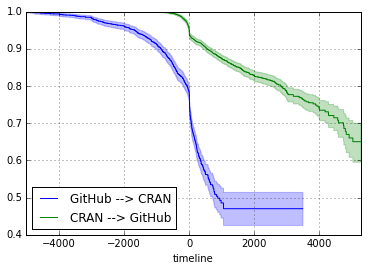

In [70]:
ax = plt.subplot()

loc = survival.dropna(subset=('GitHubFirstDate',),)
T, E = lifelines.utils.datetimes_to_durations(loc['GitHubFirstDate'], loc['CRANFirstDate'], fill_date=fill)
kmf.fit(T, event_observed=E, label='GitHub --> CRAN').plot(ax=ax)

loc = survival.dropna(subset=('CRANFirstDate',),)
T, E = lifelines.utils.datetimes_to_durations(loc['CRANFirstDate'], loc['GitHubFirstDate'], fill_date=fill)
kmf.fit(T, event_observed=E, label='CRAN --> GitHub').plot(ax=ax)

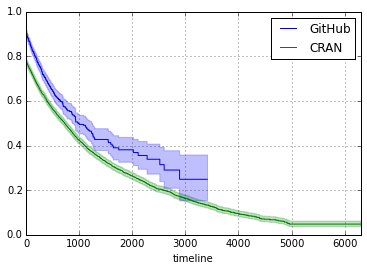

In [68]:
ax = plt.subplot()

limit = pandas.to_datetime(datetime.date(2015,1,1)) #datetime.date.today() - datetime.timedelta(weeks=13)


loc = survival.dropna(subset=('GitHubFirstDate',),)

_F = lambda r: r if r < limit else ''

T, E = lifelines.utils.datetimes_to_durations(loc['GitHubFirstDate'], loc['GitHubLastDate'].apply(_F), fill_date=fill)
kmf.fit(T, event_observed=E, label='GitHub').plot(ax=ax)

loc = survival.dropna(subset=('CRANFirstDate',),)
T, E = lifelines.utils.datetimes_to_durations(loc['CRANFirstDate'], loc['CRANLastDate'].apply(_F), fill_date=fill)
kmf.fit(T, event_observed=E, label='CRAN').plot(ax=ax)